## Hypothesis Test with study of LEE 

We repeat again the same hypothesis test on the same problem, but now we keep varying one (or all) the signal parameters such as the mass and the width of the signal. 

We show that the extimated p-value is not following anymore the 1 degree of freedom $\chi^2$ distribution. 


In [1]:
using namespace RooStats;

In [2]:
HypoTestResult * result = nullptr;
ProfileLikelihoodTestStat * testStat = nullptr; 
ToyMCSampler * toymcs = nullptr; 
HypoTestPlot * plot = nullptr; 
// enable use of NLL offset for better minimizations
RooStats::UseNLLOffset(true);
//ROOT::Math::MinimizerOptions::SetDefaultMinimizer("Minuit2");


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



#### Reading the model (Workspace) from input file

First part is just to access the workspace file and retrieve the model and the data 

In [3]:
TString fileName ="HiggsBinModel.root";  
TString workspaceName = "w";
TString modelConfigName = "ModelConfig";
TString dataName = "data";
TString integrationType = "";  

In [4]:
auto file = TFile::Open(fileName);

In [5]:
auto w =  (RooWorkspace*) file->Get(workspaceName);
w->Print();
auto sbModel = (RooStats::ModelConfig*) w->obj(modelConfigName);
auto  data = w->data(dataName);
auto poi = (RooRealVar*) sbModel->GetParametersOfInterest()->first();
// the workspace contains the number of observed events
int nevt_obs = poi->getVal(); 


RooWorkspace(w) w contents

variables
---------
(a1,a2,mass,nbackground,nsignal,width,x)

p.d.f.s
-------
RooExponential::bmodel[ x=z c=1 ] = 0.000354025
RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000350859
RooGaussian::smodel[ x=x mean=mass sigma=width ] = 1.8233e-12

functions
--------
RooFormulaVar::z[ actualVars=(a1,a2,x) formula="-(a1*x/100.+a2*(x/100.)^2)" ] = -7.94614

datasets
--------
RooDataHist::data(x)

named sets
----------
ModelConfig_NuisParams:(a1,a2,nbackground)
ModelConfig_Observables:(x)
ModelConfig_POI:(nsignal)
nuisParams:(a1,a2,nbackground)

generic objects
---------------
RooStats::ModelConfig::ModelConfig



##### Make the b Model by cloning the b model and use a value = 0 for the parameter of interest

In [6]:
auto bModel = (RooStats::ModelConfig*) sbModel->Clone();
sbModel->SetName("S+B Model");
poi->setVal(250);
sbModel->SetSnapshot( *poi);
bModel->SetName("B Model");
poi->setVal(0);
bModel->SetSnapshot( *poi  );
sbModel->Print();
bModel->Print();
poi->setVal(nevt_obs);


=== Using the following for S+B Model ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (nsignal)
Nuisance Parameters:     RooArgSet:: = (a1,a2,nbackground)
PDF:                     RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000354025
Snapshot:                
  1) 0x125301690 RooRealVar:: nsignal = 250 +/- 93.6477  L(0 - 1000)  "nsignal"


=== Using the following for B Model ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (nsignal)
Nuisance Parameters:     RooArgSet:: = (a1,a2,nbackground)
PDF:                     RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000354025
Snapshot:                
  1) 0x10dd7d560 RooRealVar:: nsignal = 0 +/- 93.6477  L(0 - 1000)  "nsignal"



#### Make the signal parameters varying in the fit

To study the LEE we do not fix the mass of the signal peak, we must keep it varying

Again we fix the background parameters to speed-up the fitting time for the toys

In [7]:
w->var("mass")->setConstant(false);
w->var("width")->setConstant(true);
w->var("a1")->setConstant(true);
w->var("a2")->setConstant(true);

### Run the Frequentist Calculator

We run now on the same model the FrequentistCalculator. The Frequentist Calculator uses the test statistic distributions obtained with pseudo-experiments.

In [8]:
RooStats::FrequentistCalculator   fc(*data, *sbModel, *bModel);
// to enable Proof
RooStats::ProofConfig pc(*w, 0, "", kFALSE);

We configure the Frequentist calculator by specifying the number of toys for the two hypothesis 

We need also to specify the test statistics type. Here are some possible test statistics to use 

In [9]:
testStat = new RooStats::ProfileLikelihoodTestStat(*sbModel->GetPdf());
// needed for PL test statistics
testStat->SetOneSidedDiscovery(true);
// to enable debug of fitting toys
//testStat->SetPrintLevel(-1);

In [10]:
toymcs = (RooStats::ToyMCSampler*)fc.GetTestStatSampler();
toymcs->SetTestStatistic(testStat);
toymcs->SetGenerateBinned(true);
// toymcs->SetProofConfig(&pc);    // to use PROOF 

#### Set the number of pseudo-experiments

We generate toys only for the null hypothesis. Not interested now in the expected significance

In [11]:
fc.SetToys(2000,1);   

#### Run now the calculator

It can take some time... be patient 

In [12]:
tw = new TStopwatch(); tw->Start(); 
result = fc.GetHypoTest(); 
result->Print();
tw->Print();


=== Using the following for B Model ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (nsignal)
Nuisance Parameters:     RooArgSet:: = (a1,a2,nbackground)
PDF:                     RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000350861
Snapshot:                
  1) 0x125988790 RooRealVar:: nsignal = 0 +/- 93.6477  L(0 - 1000)  "nsignal"


=== Using the following for S+B Model ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (nsignal)
Nuisance Parameters:     RooArgSet:: = (a1,a2,nbackground)
PDF:                     RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000350861
Snapshot:                
  1) 0x125988780 RooRealVar:: nsignal = 250 +/- 93.6477  L(0 - 1000)  "nsignal"

[#0] PROGRESS:Generation -- Test Statistic on data: 7.99411
[#1] INFO:InputArguments -- Profiling conditional MLEs for Null.
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Null.
[#0

#### Plot now the test statistics distribution for the null hypothesis (B only)

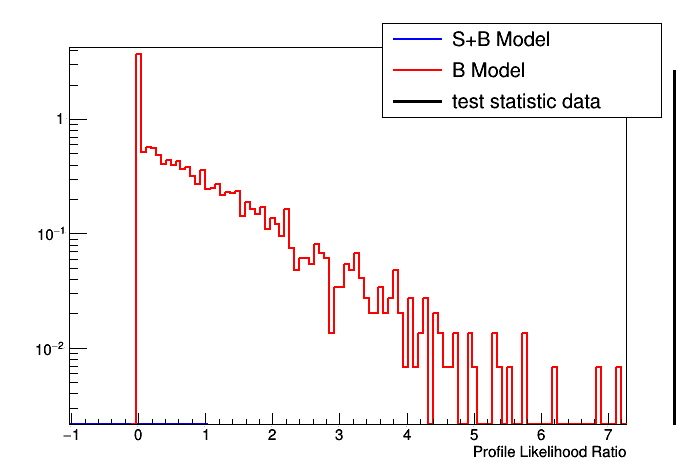

[#0] WARNING:Plotting -- Could not determine xmin and xmax of sampling distribution that was given to plot.


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [13]:
plot = new RooStats::HypoTestPlot(*result);
plot->SetLogYaxis(true);
plot->Draw();
gPad->Draw();

We save the result in a file. We don;t want to loose the resulting information if we have run toys for some time. 

In [14]:
fileOut = TFile::Open("HypoTestResult.root","RECREATE");
result->Write();
fileOut->Close();

### Is Test statistic distribution like a chi-square distribution with n.d.f =1 ? 

We want to fit the null test statistic distribution to check if it is compatible with a chi2 distribution

In [15]:
dist = result->GetNullDistribution();
vec = dist->GetSamplingDistribution();
cout << "number of generated null toys = " << vec.size() << endl;

hdist = new TH1D("hdist","Test Statistic distribution",200,0,10);
hdist->FillN(vec.size(),vec.data(),nullptr);
// merge all underflows (failing fits) in the first bin (bin 0)
hdist->SetBinContent(1, hdist->GetBinContent(0)+hdist->GetBinContent(1));

number of generated null toys = 2000


Create the fit function as a 1/2 chisquared. Special case for forst bin (x < 0.05) 
Also the quantity plotted is the log-likelihood ratio and not 2 x log-likelihood ratio .
0.05 is the histogram bin width. 

In [16]:
fchi2 = new TF1("chi2","[](double*x,double*p){ if (x[0] < 0.05) { return 0.5*p[0]+ 0.5*p[0]*ROOT::Math::chisquared_cdf(0.1,p[1]); } else { return 0.05*p[0]*ROOT::Math::chisquared_pdf(2*x[0],p[1]); } }",0.,10.,2,1);

##### Comparison of test statistic distribution vs 1/2 $\chi^2$ distribution with *ndf = 1*

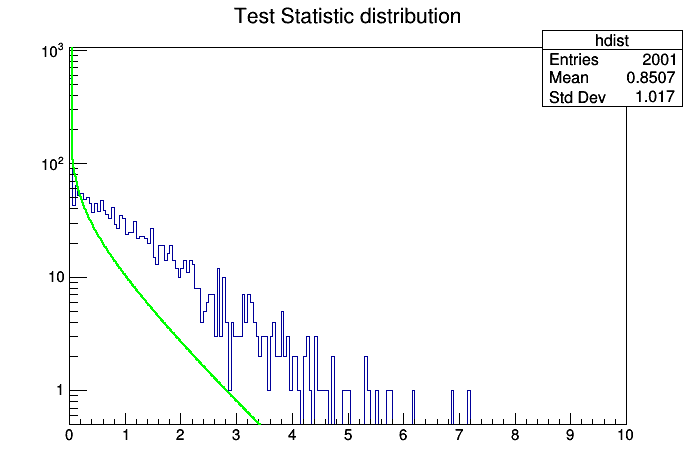

In [17]:
hdist->Draw();
fchi2->SetParameters(vec.size(),1);
fchi2->SetNpx(1000);
fchi2->SetLineColor(kGreen);
fchi2->DrawCopy("SAME");
fchi2->SetLineColor(kRed);
gPad->Draw();

#### Fit obtained distribution with  1/2 $\chi^2$ 

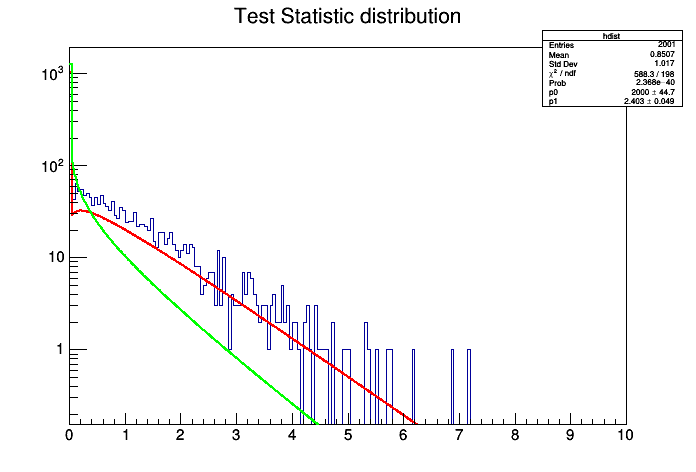

 FCN=279.609 FROM MIGRAD    STATUS=CONVERGED      41 CALLS          42 TOTAL
                     EDM=3.51295e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.00008e+03   4.47232e+01   5.16850e-01   2.34286e-08
   2  p1           2.40315e+00   4.90742e-02   5.67072e-04  -3.81924e-03
                               ERR DEF= 0.5


In [18]:
// do integral fit 
hdist->Fit(fchi2,"L I ","SAME");
gStyle->SetOptFit(1111);
gPad->Draw();